In [1161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
from scipy.interpolate import make_interp_spline, BSpline, interp1d, pchip, InterpolatedUnivariateSpline
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from sympy import symbols, Eq, solve
from scipy.integrate import quad

## Hausaufgabe

In [1162]:
a, b, V, nu, p, R, T = symbols('a b V nu p R T')
eq = Eq((p+((nu**2)*a)/V**2)*(V-nu*b),nu*R*T)
res = solve(eq, p)
res

[nu*(R*T*V**2 - V*a*nu + a*b*nu**2)/(V**2*(V - b*nu))]

In [1163]:
a = 3.6e-1#(Pa * m6)/mol2
b = 4.3e-5 #m3/mol
nu = 1
T = 288.7
R = constants.R
print(R)

8.314462618


In [1164]:
def iso_288(v):
    return ((R*T)/(v-b))-(a/(v**2))

In [1165]:
V = np.linspace(1, 500, 10000)
p = (((R*T)/(V * 1e-6 -b))-(a/((V*1e-6)**2))) * 1e-5

(55.0, 80.0)

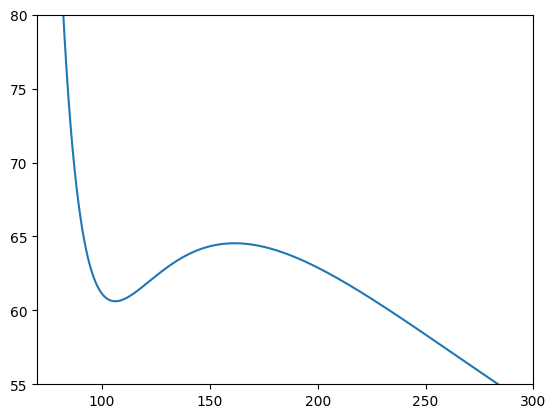

In [1166]:
fig, ax = plt.subplots(dpi=100)
plt.plot(V, p)
ax.set_xlim(70, 300)
ax.set_ylim(55, 80)


In [1167]:
file_path1 = '/Users/danielmiksch/Downloads/C31_30_8.csv'
file_path2 = '/Users/danielmiksch/Downloads/C31_35_8.csv'
file_path3 = '/Users/danielmiksch/Downloads/C31_40_8 .csv'
# file_path4 = '/Users/danielmiksch/Downloads/C31_43_0 .csv'

data_30_8 = pd.read_csv(file_path1, sep=',')
data_35_8 = pd.read_csv(file_path2, sep=',')
data_40_8 = pd.read_csv(file_path3, sep=',')
# data_43_0 = pd.read_csv(file_path4, sep=',')

In [1168]:
def error_array(array, sx, sy):
    err_x = np.full((len(array), 1), sx)
    err_y = np.full((len(array), 1), sy)
    return np.hstack((array, err_x, err_y))

In [1169]:
dV = 0.05
dP = 0.2

In [1170]:
a_SF6 = 7.857e-1
b_SF6 = 8.79e-5
x = np.linspace(.1, 5, 10000)

In [1171]:
# def isotherm(V, T):
#     return (((R*(T+273.15))/(V * 1e-6 -b_SF6))-(a_SF6/((V*1e-6)**2))) * 1e-5

In [1172]:
np.set_printoptions(suppress=True, precision=10)
data_30_8 = error_array(data_30_8.to_numpy(), dV, dP)
data_35_8 = error_array(data_35_8.to_numpy(), dV, dP)
data_40_8 = error_array(data_40_8.to_numpy(), dV, dP)
# data_43_0 = data_43_0.to_numpy()

Beta: [-6.9585871787 35.5647078346]
Beta Std Error: [0.3181202311 0.5933287846]
Beta Covariance: [[ 1.0639905922 -1.9772489746]
 [-1.9772489746  3.7012297606]]
Residual Variance: 0.09511407542423607
Inverse Condition #: 0.030619641775774233
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-331.2757560056  143.1178101404]
Beta Std Error: [56.8406637418 18.6332361583]
Beta Covariance: [[ 332058.2765934592 -108749.0834912413]
 [-108749.0834912413   35683.9239225704]]
Residual Variance: 0.009729801310046497
Inverse Condition #: 0.01094323380075122
Reason(s) for Halting:
  Sum of squares convergence
Beta: [24.7090909091]
Beta Std Error: [0.0680301343]
Beta Covariance: [[0.0036363636]]
Residual Variance: 1.2727272727272712
Inverse Condition #: 1.0
Reason(s) for Halting:
  Both sum of squares and parameter convergence
[[  -6.9585871787   35.5647078346]
 [-331.2757560056  143.1178101404]
 [   0.             24.7090909091]]


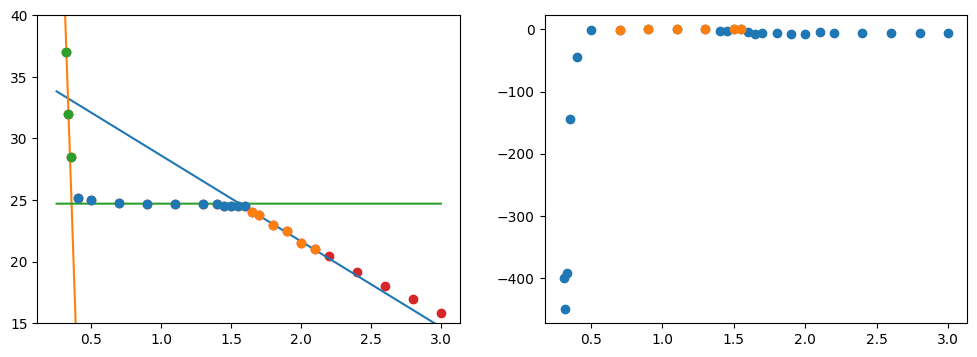

In [1173]:
def maxwell_tie_line(data, threshold, range, end=None):
    x = data[:,0]
    y = data[:,1]
    sx = data[:,2]
    sy = data[:,3]
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    sx = sx[sorted_indices]
    sy = sy[sorted_indices]
    x_plot = np.linspace(0.25, 3, 10000)
    dy_dx = np.gradient(y, x)
    # index_array = np.where(dy_dx>-threshold)[0]
    x_coex = x[range[0]:range[1] + 1]
    sx_coex = sx[range[0]:range[1] + 1]
    x_sat = x[:range[0]]
    sx_sat = sx[:range[0]]
    if end is not None:
        x_lin = x[range[1] + 1:end + 1]
        sx_lin = sx[range[1] + 1:end + 1]
    else:
        x_lin = x[range[1] + 1:]
        sx_lin = sx[range[1] + 1:]
    y_coex = y[range[0]:range[1] + 1]
    sy_coex = sy[range[0]:range[1] + 1]
    y_sat = y[:range[0]]
    sy_sat = sy[:range[0]]
    if end is not None:
        y_lin = y[range[1] + 1:end + 1]
        sy_lin = sy[range[1] + 1:end + 1]
    else:
        y_lin = y[range[1] + 1:]
        sy_lin = sy[range[1] + 1:]
    beta_array = np.empty((0,2))
    def model_sat_lin(p, x):
        a, b = p
        return a*x+b
    model = Model(model_sat_lin)
    for i in [[x_lin, y_lin, sx_lin, sy_lin], [x_sat, y_sat, sx_sat, sy_sat]]:
        data_fit = RealData(i[0], i[1], sx=i[2], sy=i[3])
        odr = ODR(data_fit, model, beta0=[3, 1])
        output = odr.run()
        output.pprint()
        beta_array = np.vstack((beta_array, output.beta))
    def model_coex(p, x):
        b = p
        return 0*x+b
    model = Model(model_coex)
    data_fit = RealData(x_coex, y_coex, sx=sx_coex, sy=sy_coex)
    odr = ODR(data_fit, model, beta0=[20])
    output = odr.run()
    output.pprint()
    beta_array = np.vstack((beta_array, [0, output.beta[0]]))

    print(beta_array)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.scatter(x_coex, y_coex, zorder=3)
    ax1.scatter(x_lin, y_lin, zorder=3)
    ax1.scatter(x_sat, y_sat, zorder=3)
    ax1.scatter(x, y)
    ax1.plot(x_plot, model_sat_lin(beta_array[0], x_plot))
    ax1.plot(x_plot, model_sat_lin(beta_array[1], x_plot))
    ax1.plot(x_plot, model_sat_lin(beta_array[2], x_plot))
    ax1.set_ylim(15, 40)
    # ax.set_xlim(0, 3.2)
    ax2.scatter(x, dy_dx)
    ax2.scatter(x[dy_dx>-threshold], dy_dx[dy_dx>-threshold])
    

maxwell_tie_line(data_30_8, 1, [4,14], 20)

# test = np.array([1,1,1,1,2,2,2,2,2,1,1,1,1])
# test1 = np.where(test >=2)[0]
# test[test1[-1]+1:]

    

In [1174]:
# def isotherm_fit(x, nu, T):
#     # nu_fit  = p
#     return nu*(R*T*(x*1e-6)**2 - (x*1e-6)*a_SF6*nu + a_SF6*b_SF6*nu**2)/((x*1e-6)**2*((x*1e-6) - b_SF6*nu)) * 1e-5

In [1175]:
# popt, pcov = curve_fit(isotherm_fit, data_30_8[:,0], data_30_8[:,1], sigma=data_30_8[:,3], absolute_sigma=True, p0=[3, 310])
# popt

In [1176]:
interp_iso = interp1d(data_30_8[:,0], data_30_8[:,1], kind='linear')

In [1177]:
x = np.linspace(min(data_30_8[:,0]), max(data_30_8[:,0]), 1000)

<ErrorbarContainer object of 3 artists>

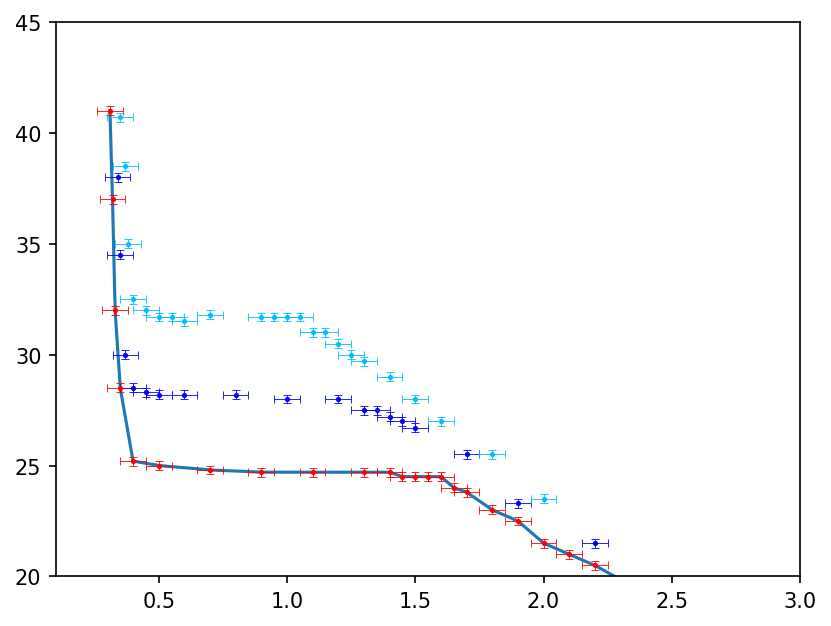

In [1178]:
fig, ax = plt.subplots(dpi=150)

ax.set_xlim(.1, 3)
ax.set_ylim(20, 45)
plt.plot(x, interp_iso(x))
plt.errorbar(data_30_8[:,0], data_30_8[:,1],
             xerr=data_30_8[:,2], yerr=data_30_8[:,3],
             capsize=2, ecolor='red', elinewidth=0.4, capthick=0.4,
             markersize=5, fmt=".", markeredgecolor='none', c="red",
             zorder=2,
             label='T=30,8°C')
plt.errorbar(data_35_8[:,0], data_35_8[:,1],
             xerr=data_35_8[:,2], yerr=data_35_8[:,3],
             capsize=2, ecolor='blue', elinewidth=0.4, capthick=0.4,
             markersize=5, fmt=".", markeredgecolor='none', c="blue",
             zorder=2,
             label='T=35,8°C')
plt.errorbar(data_40_8[:,0], data_40_8[:,1],
             xerr=data_40_8[:,2], yerr=data_40_8[:,3],
             capsize=2, ecolor='deepskyblue', elinewidth=0.4, capthick=0.4,
             markersize=5, fmt=".", markeredgecolor='none', c="deepskyblue",
             zorder=2,
             label='T=40,8°C')

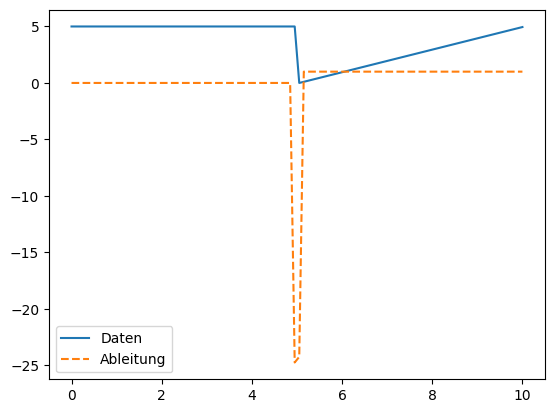

In [1179]:

# Erstellen Sie eine Datenreihe mit konstanten und nicht-konstanten Teilen
x = np.linspace(0, 10, 100)
y = np.concatenate([np.full(50, 5), x[:50]])

# Verwenden Sie numpy.gradient, um die Ableitung zu berechnen
dy_dx = np.gradient(y, x)

# Plotten
plt.plot(x, y, label='Daten')
plt.plot(x, dy_dx, label='Ableitung', linestyle='--')
plt.legend()
plt.show()
